# Wordgame Word2Vec features
Welcome to the second notebook in my wordgame project. In this notebook our goal is to extract a the similarity of the word pairs based on Word2Vec. Word2Vec is a model.. 

a) open tail
b) compute sim 
1) Compare sim with sim of random word pairs (shift) 
2) Plot all sim dists 
3) Plot specific. word 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.palplot(sns.color_palette("Paired", 10))

#because sometimes you need  to be more specific?
pal = sns.color_palette("Paired", 10)

#
df = pd.read_csv('../data/processed/wordgame_20170807_english.csv', dtype={'nt': np.bool, 'word1':str, 'word2':str})
#
df['word'] = df['word'].astype(str)
df['association'] = df['association'].astype(str)

#load the alphabetical list of source names
with open('../data/processed/sources.csv') as f:
    sources_list = f.read().splitlines()
    
df.head()

,user,forum,word,association,forumID,english1,english2,tf1,tf2
0,My smile is relief,U2,children,cute,8,True,True,92,79
1,Habanerose,GOG,journey,adventure,4,True,True,65,65
2,Judge,AC,listerine,antiseptic,0,False,True,4,5
3,Kleetus,GOG,whale,hello,4,True,True,57,48
4,le_chevalier,GOG,no,conspiracy,4,True,True,102,35


In [3]:
from gensim.models.keyedvectors import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('../data/external/GoogleNews-vectors-negative300.bin', binary=True)
print('Loaded word embeddings')

Loaded word embeddings


In [5]:
#
def inVocab(r):
    if (r.word in w2v_model.vocab) & (r.association in w2v_model.vocab):    
        return True
    return False


#df['word'] = df['word'].apply(lambda x:x.replace(" ","_"))
#df['association'] = df['association'].apply(lambda x:x.replace(" ","_"))                 
df['invoc'] = df.apply(inVocab, axis=1)

#
def calcVec(r): 
    if r.invoc:
        return (w2v_model.word_vec(r.word), w2v_model.word_vec(r.association)) 
    else:
        return (np.zeros(300), np.zeros(300))
    
df['wv1'],df['wv2'] = zip(*df.apply(calcVec, axis=1))

#
def similarity(r):
    if r.invoc:
        return w2v_model.similarity(r.word, r.association)
    else:
        return 0

df['sim'] = 0    
df['sim'] = df.apply(similarity, axis=1) 
print("finished")

print("Percentage of words in vocabulary: " + str(df['invoc'].mean()*100)) #93,3

finished
Percentage of words in vocabulary: 93.3381358166


In [6]:
#only consider pairs found in vocabulary 
voc_sample = df[df['invoc']]

print("Number of remaining word pairs: " +str(len(voc_sample)))
print("Mean similariy score: " +str(voc_sample['sim'].mean()))
print("Median similariy score: " +str(voc_sample['sim'].median()))
print("Minimum similariy score: " +str(voc_sample['sim'].min()))

Number of remaining word pairs: 265617
Mean similariy score: 0.269332850989
Median similariy score: 0.23703950846221972
Minimum similariy score: -0.160809888703


...

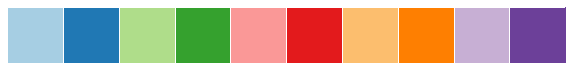

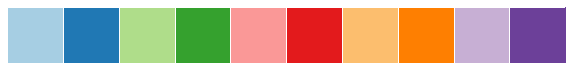

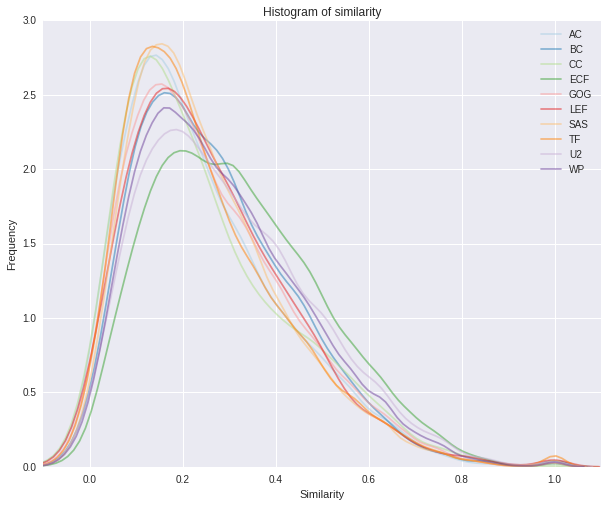

In [7]:
#
plt.figure(figsize=(22, 8))
plt.subplot(1,2,1)
for i in range(0,10,1):
    s = voc_sample[voc_sample['forumID']==i]
    sns.kdeplot(s['sim'], alpha=0.5, label=s.iloc[0]['forum'], color=pal[i])  
plt.title('Histogram of similarity')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
axes = plt.gca()
axes.set_xlim([-0.1,1.1])

plt.show()

In [17]:
# similar
most_impr = voc_sample[voc_sample['sim']<0.91].sort_values(by=['sim'], ascending=False).drop_duplicates(subset=['word','association']).head()
print(most_impr[['word','association','sim']])

df['af'] = df.groupby(['user','forum'])['user'].transform('count')

ecf = df[df['forum']=="ECF"][:]
ecf = ecf[ecf['af']>2]
ecf['meansim'] = 

print(ecf['user'].nunique()) #268 users (maybe remove 1-users...)
#todo (scatter/box)plot mean sim (or TSNE1+TSNE2) for each user in ECF.?

              word association       sim
75459   incredible     amazing  0.905400
39243      amazing  incredible  0.905400
180956   disappear      vanish  0.900423
252610      vanish   disappear  0.900423
59078        third      fourth  0.900242
132


...

# TSNE



In [76]:
from sklearn.manifold import TSNE

sampleA = voc_sample[(voc_sample['word1'].isin(["music"]))][:]
sampleA['group'] = 0
sampleB = voc_sample[(voc_sample['word1'].isin(["time"]))][:]
sampleB['group'] = 1
sample = pd.concat([sampleA, sampleB])
sample['c'] = sample.groupby(['word2','group'])['word2'].transform('count') 
 
print("Number of words in sample: "+ str(len(sample)))

Number of words in sample: 1024


In [77]:
# Compute reduced word-vectors
model = TSNE(random_state=24).fit_transform(sample['wv2'].tolist()) 
sample['x'] = model[:,0]
sample['y'] = model[:,1]

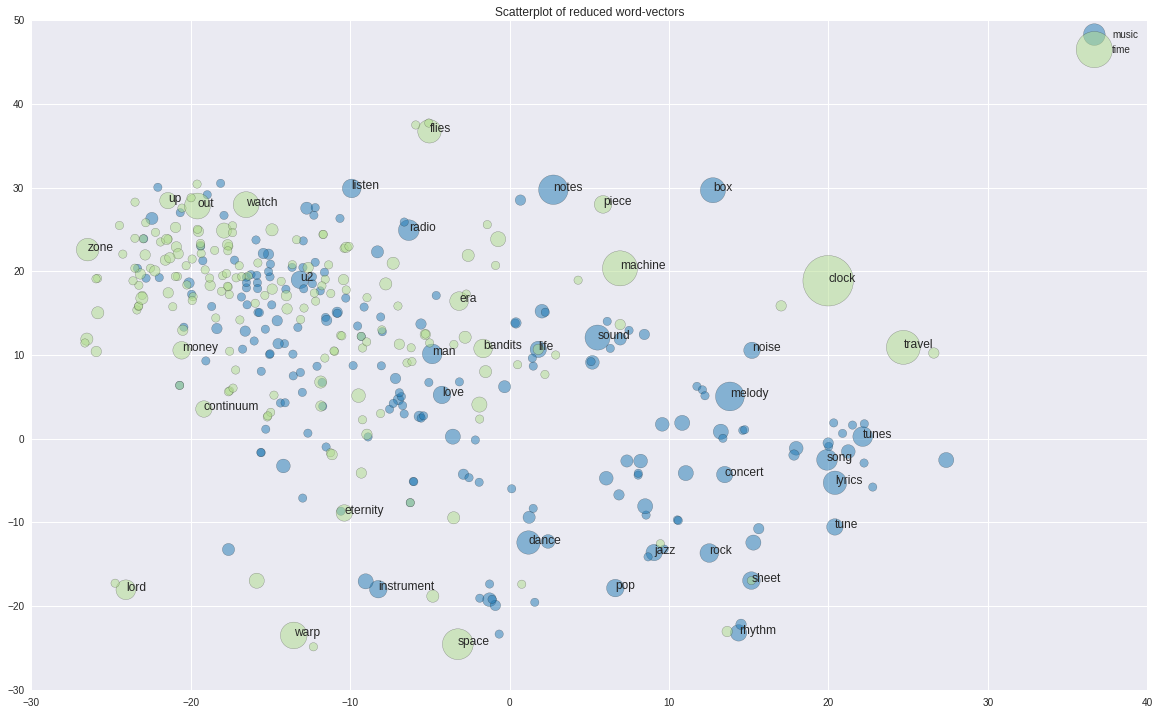

In [78]:
sample = sample.drop_duplicates(subset=['word2','group']) 
labels = ["music","time"]
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(12)
for i in range(0,2):
    s = sample[sample['group']==i]
    ax.scatter(s.x, s.y, marker='o', s=30+40*s.c, c=pal[i+1], alpha=0.5, label=labels[i])
    for j in range(0,len(s)):
        if(s.c.iloc[j] > 5):
            ax.annotate(s.word2.iloc[j], (s.x.iloc[j], s.y.iloc[j]))
        
plt.title('Scatterplot of reduced word-vectors')
plt.legend(loc='upper right')
#axes = plt.gca()
axes.set_xlim([-25,25])
axes.set_ylim([-25,25])
plt.show()

...

In [115]:
# will result in false positives like ... ? 
# this COULD represent the relation between words but is not always correct
 
df['rel1'] = df.apply((str(r.word1 + "_" + r.word2) in w2v_model.vocab), axis=1)
df['rel2'] = df.apply((str(r.word2 + "_" + r.word1) in w2v_model.vocab), axis=1)
df['rel3'] = df.apply((str(r.word1 + r.word2) in w2v_model.vocab), axis=1)
df['rel4'] = df.apply((str(r.word2 + r.word1) in w2v_model.vocab), axis=1)


def extend_word(r):
    if r.word1 not in w2v_model.vocab:
        return (r.word2, r.sim, 0)
    
    extended1 = r.word1 + "_" + r.word2 
    extended2 = r.word2 + "_" + r.word1
    extended3 = r.word1 + r.word2
    extended4 = r.word2 + r.word1
    
    sim1 = sim2 = sim3 = sim4 = 0
    if (extended1 in w2v_model.vocab):
        sim1 = w2v_model.similarity(r.word1, extended1)
    if (extended2 in w2v_model.vocab):
        sim2 = w2v_model.similarity(r.word1, extended2)
    if (extended3 in w2v_model.vocab):
        sim3 = w2v_model.similarity(r.word1, extended3)
    if (extended4 in w2v_model.vocab):
        sim4 = w2v_model.similarity(r.word1, extended4)
        
    best_sim = r.sim
    best_word = r.word2
    extend_type = 0
    if(sim1 > best_sim):
        best_sim = sim1
        best_word = extended1
        extend_type = 1
    if(sim2 > best_sim):
        best_sim = sim2
        best_word = extended2
        extend_type = 2
    if(sim3 > best_sim):
        best_sim = sim3
        best_word = extended3
        extend_type = 3
    if(sim4 > best_sim):
        best_sim = sim4
        best_word = extended4
        extend_type = 4
        
    return (best_word, abs(best_sim-r.sim), extend_type)

df['word2_extended'],df['improv'],df['extend_type'] = zip(*df.apply(extend_word, axis=1))

voc_sample = df[df['invoc']]

print(voc_sample['sim_extended'].mean())
print("Percentage of pairs with improved similarity score: " + str((voc_sample['extend_type']>0).mean()*100)) 

0.286146437909
Percentage of pairs with improved similarity score: 11.5239470152


In [116]:
# show words with biggest improvemnt

most_impr = voc_sample[voc_sample['extend_type']>0].sort_values(by=['improv'], ascending=False).drop_duplicates(subset=['word2'])
print(most_impr[['word1','word2','word2_extended','improv']])

                  word1         word2           word2_extended    improv
219913        microsoft        office         microsoft_office  0.802723
142064            nurse    registered         registered_nurse  0.764343
320442           pandas         giant             giant_pandas  0.764027
257724           island             s                  islands  0.754110
190634        biography          auto            autobiography  0.747846
207788         daughter         grand            granddaughter  0.746060
149148             wrap          ping                 wrapping  0.741757
245855              gas       natural              natural_gas  0.733138
106640             name           sur                  surname  0.707802
7371             sewage           raw               raw_sewage  0.704268
224944          variety          wide             wide_variety  0.698198
17021             quake         earth               earthquake  0.691886
253999          boomers          baby             b

In [113]:
clean = voc_sample[voc_sample['extend_type']==0]
print("Mean similariy score: " +str(clean['sim'].mean()))

Mean similariy score: 0.276530252108
